# 03 - Análise de Dados Exploratória (EDA)
Autora: Fernanda Baptista de Siqueira  
Curso: MBA em Tecnologia para Negócios – AI, Data Science e Big Data  
Tema: Análise de Acidentes de Trânsito em Porto Alegre (2020–2024)  
Origem DataFrame: Equipe Armazém de Dados de Mobilidade - EAMOB/CIET  
https://dadosabertos.poa.br/dataset/acidentes-de-transito-acidentes (11/05/2025)  

### 1. Importa bibliotecas, funções e Dataset

In [5]:
from config import (
    pd, np, plt, sns, graf_heatmap,
    graf_contagem, graf_crosstab, 
    graf_temporal, ordenar_dias_semana,
    PATH_CLEAN
)
df = pd.read_parquet(PATH_CLEAN + 'df_20_24_chuva.parquet')

### 2. Visualização do Dados
1) Temporal

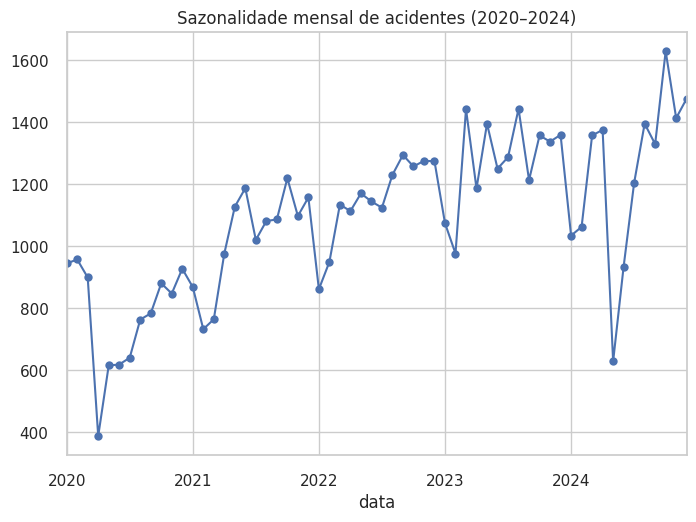

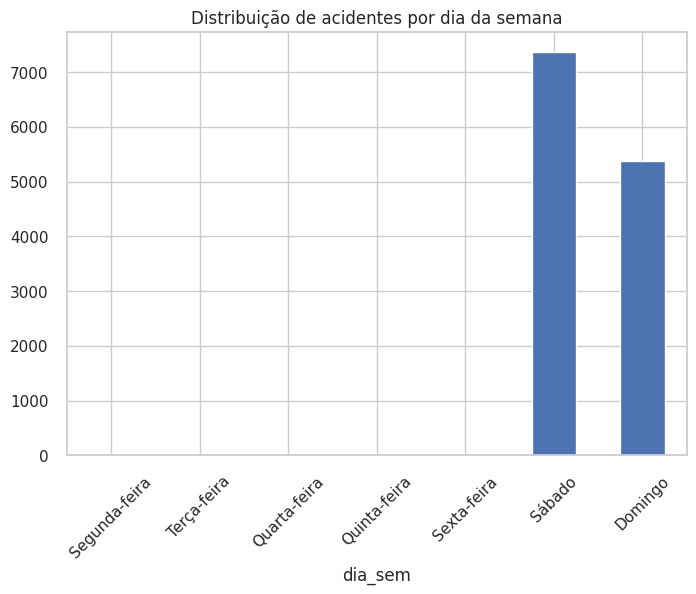

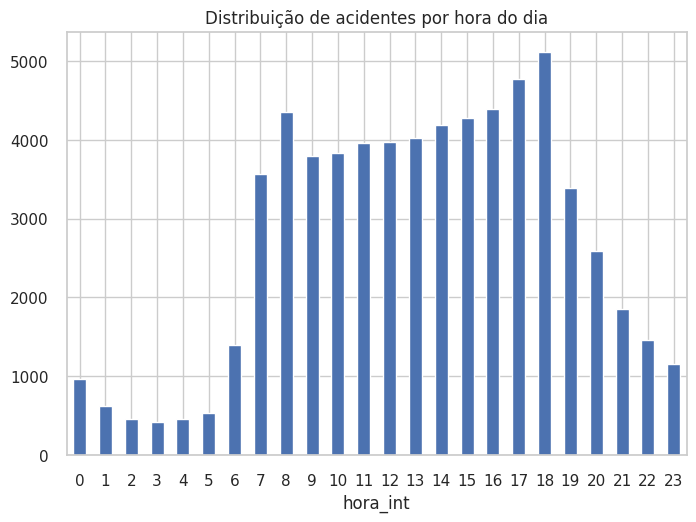

In [6]:
# Distribuição por ano e mês# Sazonalidade mensal
graf_temporal(df, "data", "idacidente", freq="M", titulo="Sazonalidade mensal de acidentes (2020–2024)")

# Dias da semana
df = ordenar_dias_semana(df, "dia_sem")
graf_contagem(df, "dia_sem", "Distribuição de acidentes por dia da semana", rotacao=45)

# Horário do dia
graf_contagem(df, "hora_int", "Distribuição de acidentes por hora do dia")



2. Tipo de Acidentes

In [ ]:
# Top 10 tipos de acidente
df_plot = (
    df["tipo_acid"]
    .replace("NAO CADASTRADO", np.nan)   # trata como missing
    .dropna()                            # remove para visualização
)

df_plot.value_counts().head(10).iloc[::-1].plot(kind="barh", figsize=(8,5))
plt.title("Top 10 tipos de acidente")
plt.show()


# Veículos mais envolvidos
df[cols_veiculos].sum().sort_values().plot(kind="barh")
plt.title("Total dos principais veículos envolvidos")
plt.show()


# Agrupa por tipo de acidente e soma vítimas
acidentes_vitimas = (
    df.groupby("tipo_acid")["total_vitimas"]
    .sum()
    .sort_values(ascending=False)
)

# Plot
acidentes_vitimas.head(10).plot(
    kind="barh", figsize=(8,5)
)
plt.title("Tipos de acidente com maior número de vítimas (2020–2024)")
plt.xlabel("Total de vítimas")
plt.ylabel("Tipo de acidente")
plt.gca().invert_yaxis()  # deixa o maior no topo
plt.show()

3. Localização

In [ ]:
# Acidentes por região
sns.countplot(x="regiao", data=df,
              order=df["regiao"].value_counts().index)
plt.title("Distribuição de acidentes por região")
plt.show()

# Hotspots por logradouro
df["log1"].value_counts().head(10).sort_values().plot(kind="barh")
plt.title("Top 10 logradouros com mais acidentes")
plt.show()


4. Condições Externas

In [ ]:
# Acidentes por turno (dia/noite)
sns.countplot(x="noite_dia", data=df)
plt.title("Acidentes por turno do dia")
plt.show()

# Severidade por turno
df_turno = df.groupby("noite_dia")[["feridos","fatais"]].sum()
print(df_turno)


5. Envolvidos

In [ ]:
# Comparar proporção de acidentes com motos vs. automóveis
total_veic = df[["auto","moto"]].sum()
total_veic.plot(kind="bar")
plt.title("Comparação entre autos e motos envolvidos")
plt.show()

# Evolução temporal do envolvimento de bicicletas
evolucao_veiculos(df_20_24, cols_veiculos)

# Para cada veículo: soma feridos / soma acidentes em que ele aparece
proporcao_feridos = {}
for veic in cols_veiculos:
    total_acidentes = (df_20_24[veic] > 0).sum()
    total_feridos = df_20_24.loc[df_20_24[veic] > 0, "feridos"].sum()
    
    if total_acidentes > 0:
        proporcao_feridos[veic] = total_feridos / total_acidentes
    else:
        proporcao_feridos[veic] = 0

# Transforma em DataFrame
df_prop_feridos = (
    pd.Series(proporcao_feridos)
    .sort_values(ascending=False)
    .rename("feridos_por_acidente")
    .reset_index()
    .rename(columns={"index": "veiculo"})
)

# Plot
df_prop_feridos.plot(
    x="veiculo", y="feridos_por_acidente",
    kind="bar", figsize=(10,6), legend=False
)
plt.title("Proporção média de feridos por acidente (2020–2024)")
plt.xlabel("Veículo")
plt.ylabel("Média de feridos por acidente")
plt.xticks(rotation=45)
plt.show()

6. Severidade

In [ ]:
# Distribuição de severidade (feridos, graves, fatais)
df[["feridos","feridos_gr","fatais"]].sum().plot(kind="bar")
plt.title("Vítimas (2020–2024)")
plt.show()


# Para cada veículo, soma o total de vítimas nos acidentes em que ele aparece
veiculos_vitimas = {}
for col in cols_veiculos:
    veiculos_vitimas[col] = df.loc[df[col] > 0, "total_vitimas"].sum()

# Transforma em DataFrame ordenado
df_veic_vitimas = (
    pd.Series(veiculos_vitimas)
    .sort_values(ascending=False)
    .rename("total_vitimas")
    .reset_index()
    .rename(columns={"index": "veiculo"})
)
print(df_veic_vitimas)


# Agrupa por tipo de acidente
acidentes_fatais = (
    df.groupby("tipo_acid")["fatais"]
    .sum()
    .sort_values(ascending=False)
)
print(acidentes_fatais.head(10))

# Tipos de acidente com mais vítimas fatais
acidentes_fatais.head(10).plot(
    kind="barh", figsize=(8,6)
)
plt.title("Tipos de acidente com maior número de vítimas fatais (2020–2024)")
plt.xlabel("Total de vítimas fatais")
plt.ylabel("Tipo de acidente")
plt.gca().invert_yaxis()
plt.show()


# Cria total de fatais sem nulo para evitar erro
df["total_fatais"] = df["fatais"].fillna(0)

# Calcula total de fatais por veículo
veiculos_fatais = {}
for veic in cols_veiculos:
    veiculos_fatais[veic] = df.loc[df[veic] > 0, "total_fatais"].sum()

df_veic_fatais = (
    pd.Series(veiculos_fatais)
    .sort_values(ascending=False)
    .rename("total_fatais")
    .reset_index()
    .rename(columns={"index": "veiculo"})
)

print(df_veic_fatais.head(10))

# Veículos mais fatais
df_veic_fatais.plot(
    x="veiculo", y="total_fatais",
    kind="bar", figsize=(10,6), legend=False
)
plt.title("Veículos mais associados a vítimas fatais (2020–2024)")
plt.xlabel("Veículo")
plt.ylabel("Total de vítimas fatais")
plt.xticks(rotation=45)
plt.show()


taxa_fatais = {}
for veic in cols_veiculos:
    total_acidentes = (df[veic] > 0).sum()
    total_fatais = df.loc[df[veic] > 0, "total_fatais"].sum()
    
    if total_acidentes > 0:
        taxa_fatais[veic] = total_fatais / total_acidentes
    else:
        taxa_fatais[veic] = 0

df_taxa_fatais = (
    pd.Series(taxa_fatais)
    .sort_values(ascending=False)
    .rename("fatais_por_acidente")
    .reset_index()
    .rename(columns={"index": "veiculo"})
)

print("Taxa de vítimas fatais por veículo:\n")
display(df_taxa_fatais)